# Analyze a new reward function over some existing laps

In [1]:
import sys
sys.path.append('../')

from deepracer.tracks import TrackIO

from reward import AWSReward
from utils.loader import get_df, load_sample_complete_laps,get_files_paths
from utils.transformer import df_to_params, get_episode
from utils.new_rewards import aggregate_episode_reward, summary, plot_new_reward
from analysis.apps import create_new_reward_app
import seaborn

track = TrackIO(base_path='../tracks').load_track("reinvent_base")

logs_base_path = '../logs/'
fname = 'training-simulation-logs-z6.log'
full_df= get_df( logs_base_path + fname)

Loaded 71 waypoints


## Define or load a new reward 

The function/object it should take a dictionary of params and return an object that can be casted to float

If you have a file with a function you can try to use the ``%load`` magic to load it insted of copying it, just write ``%load path/myfile.py`` in the first line of a cell an run it.

Some reward functions are available at `../reward/reward_functions/*/reward_function.py`

In [2]:
# %load ../reward/reward_functions/RatesModel-R4/reward_function.py
# v2
import math

max_speed = 4.0

x_coord = 0
y_coord = 1

def circular_next_waypoint_after( index, wpts ):
	# we just need to make sure we wrap around at the end as i'm not sure how this works in deepracer when the car finishes one lap (and cannot debug!)
	if index < len(wpts) - 1:
		return index + 1
	else:
		return 0

# each line is [ [x1,y1], [x2,y2] ]
def angle_between( line1, line2 ):
	line1_rad = math.atan2(line1[1][y_coord] - line1[0][y_coord], line1[1][x_coord] - line1[0][x_coord])
	line2_rad = math.atan2(line2[1][y_coord] - line2[0][y_coord], line2[1][x_coord] - line2[0][x_coord])
	
	line1_angle = math.degrees(line1_rad)
	line2_angle = math.degrees(line2_rad)

	diff = abs(line1_angle - line2_angle)

	if diff > 180:
		diff = 360 - diff

	return diff	

def line_from( start_pos, end_pos ):
	return [ start_pos, end_pos ]

def reward_function(params):
	waypoints = params['waypoints']
	closest_waypoints_indices = params['closest_waypoints']
	heading = params['heading']
	reward = 1.0 if params['all_wheels_on_track'] else -0.01
	current_pos = [ params['x'], params['y'] ]

	next_point_index = closest_waypoints_indices[1]
	behind_point_index = closest_waypoints_indices[0]

	next_point_pos = waypoints[next_point_index]
	behind_point_pos = waypoints[behind_point_index]

	# look ahead to the following waypoint
	next_next_point_index = circular_next_waypoint_after(next_point_index, waypoints)
	next_next_point_pos = waypoints[ next_next_point_index ]

	# Calculate the direction in radians, arctan2(dy, dx), the result is (-pi, pi) in radians
	track_direction = math.atan2(next_next_point_pos[y_coord] - behind_point_pos[y_coord], next_next_point_pos[x_coord] - behind_point_pos[x_coord]) 

	# Convert to degrees
	track_direction = math.degrees(track_direction)

	# Calculate the difference between the track direction and the heading direction of the car
	direction_diff = abs(track_direction - heading)
	if direction_diff > 180:
		direction_diff = 360 - direction_diff

	# Penalize the reward if the difference is too large
	DIRECTION_THRESHOLD = 10.0

	if direction_diff > DIRECTION_THRESHOLD:
		reward *= 0.5

	# work out what the curve looks like ahead of us
	curve_angle = angle_between( line_from(next_next_point_pos, next_point_pos), line_from(next_point_pos, behind_point_pos ) )

	# schumacher mode on
	safe_max_speed = max_speed

	if curve_angle > 20:
		safe_max_speed = 1.0
	elif curve_angle > 10:
		safe_max_speed = max_speed * 0.5
	elif curve_angle > 5:
		safe_max_speed = max_speed

	if params['speed'] > safe_max_speed:
		speed_penalty = 0.3
	else:
		speed_penalty = (params['speed'] / max_speed)

	progress_reward = ( params['progress']**1.61 - params['steps'] )/ 300 if int(params['progress'] % 5 ) == 0 else 0.0
	reward *= speed_penalty
	reward += progress_reward

	return float(reward), curve_angle, safe_max_speed, speed_penalty, progress_reward

This next step is ugly because the namespace inside de dict comprehension overrides the index if you use enumerate

In [25]:
functions =  {'new_reward': lambda params :reward_function(params)[0], 
              'curve_angle': lambda params :reward_function(params)[1],
              'safe_max_speed': lambda params :reward_function(params)[2],
              'speed_penalty':lambda params :reward_function(params)[3],
              'progress_reward': lambda params :reward_function(params)[4]}             

In [26]:
aggregate_episode_reward?

Signature:
aggregate_episode_reward(
    df,
    reward_calculator,
    df_to_params,
    track,
    new_reward_name='new_reward',
)
Docstring:
!!! df should contain only one episode information
reward_calculator should be a callable that recieves a params dictionary and returns an object castable to float
df_to_params is a helper function that takes a series and transforms it into a dictionary of parameters
File:      ~/Code/deepracer/deepracer-analysis/utils/new_rewards.py
Type:      function


In [27]:
episode = 30
df = get_episode(full_df, episode)
for funcName, func in functions.items():
    df = aggregate_episode_reward(df, func, df_to_params, track, funcName)

You can get som meeningful summary of the episode

In [28]:
summary(df,list(functions))

,,step,closest_waypoint_index,progress,speed,time,reward,duration,new_reward,curve_angle,safe_max_speed,speed_penalty,progress_reward
iteration,episode,,,,,,,,,,,,
2,30,311,35,100.0,0.719164,00:00:20,1096.1986,20.722651,137.623949,4402.289062,965.0,55.915,96.313949


Or plot some columns 

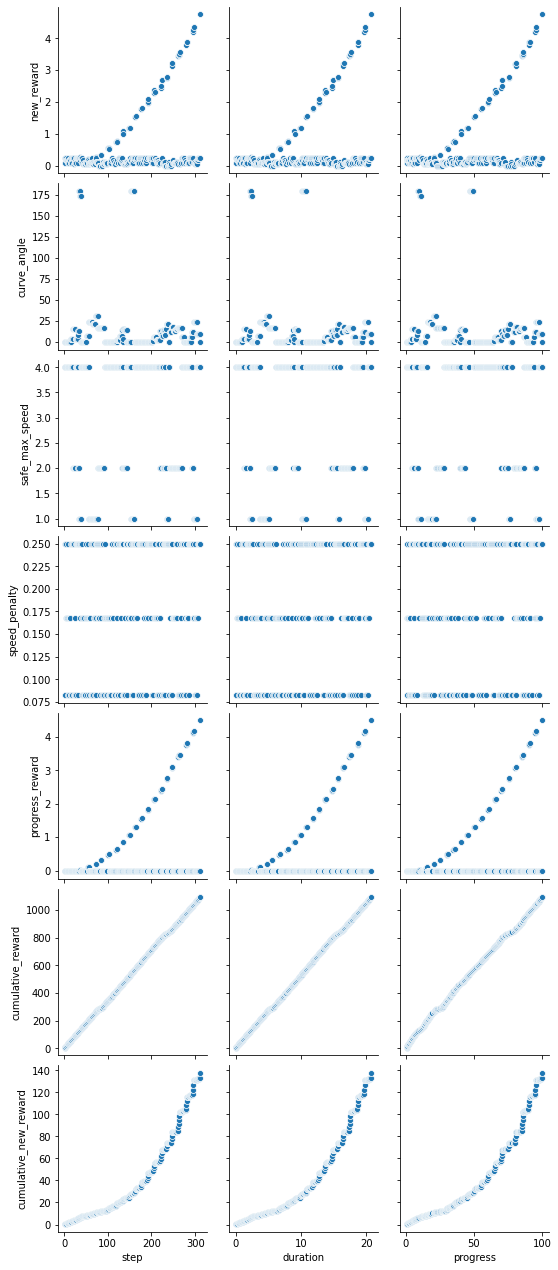

In [31]:
seaborn.pairplot(df,x_vars=['step','duration','progress'],y_vars=list(functions)+['cumulative_reward','cumulative_new_reward'], palette="husl")